In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import *

In [2]:
# Set object parameters
C = 0                      # drag coefficient -- zero out to cancel drag
x_area = 0.1                    # m^2 -- cross-sectional area
mass = 100                      # kg 

# Create dictionary entries for the planets that will be compared
PLANETS = {
    "Earth": {
        "mu":  3.986004418e14, # gravitational parameter G*M
        "R": 6_371_000, # m -- planet radius
        "rho_0": 1.225, # kg/m^3 -- air density at sea level
        "H": 8400 # scale height for atm. density calculation
    },
    "Mars": {
        "mu": 4.282837e13,
        "R":  3_389_500,
        "rho_0": 0.020,
        "H": 11_100
    },
    "Kerbin": {             # 1:10 scale Earth analog from video game Kerbal Space Program
        "mu": 3.5316e12,        
        "R":   600_000,
        "rho_0": 1.225,
        "H": 5000
    }
}

In [3]:
def curvature_radius(v_vec, a_vec):
    """
    Calculates radius of curvature in 2D using
    velocity and acceleration vectors
    R = |v|^3 / |v x a|
    """
    # Pull components from vectors
    v_r, v_t = v_vec
    ax, ay = a_vec

    # Calculate instantaneous speed
    speed = np.linalg.norm(v_vec)

    # 2D magnitude of v x a = (v_r*ay - v_t*ax)
    cross = abs(v_r*ay - v_t*ax)

    # Return curvature unless cross product = 0 
    return speed**3 / cross if cross !=0 else np.inf

def accel(state, planet):
    """
    Takes in the position and velocity
    and computes acceleration components
    that include gravity and drag
    """
    
    # Create state consisting of position and velocity components
    x,y,v_r,v_t = state

    # Get variables of planet being considered
    mu = planet["mu"]
    R = planet["R"]
    rho_0 = planet["rho_0"]
    H_scale = planet["H"]

    # Create vector arrays for position and velocity
    r_vec = np.array([x,y])
    v_vec = np.array([v_r,v_t])

    # Get magnitudes for altitude and speed
    r = np.linalg.norm(r_vec)
    speed = np.linalg.norm(v_vec)

    # Compute gravity vector
    g_vec = (-mu/r**3)*r_vec

    # Compute local atmospheric density (! needs to be updated to use piecewise regimes !)
    h = r - R
    rho_local = rho_0*np.exp(-h / H_scale) if h>= 0 else rho_0 

    # Compute drag vector as opposite of velocity vector 
    drag_vec = ( 
        -0.5 * rho_local * C * x_area/mass * speed * v_vec 
        if speed>0 else np.zeros(2)
    )

    # Create and return acceleration vector from drag and gravity 
    a_vec = g_vec + drag_vec 
    return np.array([v_r, v_t, a_vec[0], a_vec[1]])

def rk4_step(state, dt, planet):
    """
    Uses explicit RK4 integration to iterate
    over timesteps
    """
    
    k1 = accel(state, planet)
    k2 = accel(state + 0.5*dt*k1, planet)
    k3 = accel(state + 0.5*dt*k2, planet)
    k4 = accel(state + dt*k3, planet)

    return state+dt/6 * (k1 + 2*k2 + 2*k3 + k4)

def run_trajectory(v_r0,  planet, *,
                    h0=100_000,
                    dt=0.1, t_max=10000, 
                    store_path=False):
    """
    Function to run the actual trajectory and return:
    -curvature at launch 
    -impact time
    -xs,ys arrays 
    """

    theta_prev = 0.0 
    angle_travelled = 0.0
    R_orbit = np.nan 
    last_radius = None

    r0 = planet["R"] + h0
    ts, xs, ys = ([], [], []) if store_path else (None, None, None) # record actual trajectory only when necessary

    # Initial state with given horizontal velocity and altitude
    state= np.array([r0, 0.0, 0, v_r0])
    t = 0.0

    # Curvature at t=0
    a0 = accel(state, planet)[2:] # get acceleration ax and ay
    v0 = state[2:4] # get velocity
    R_launch=curvature_radius(v0, a0)

    # Progress forward until crossing surface or reaching time
    while t< t_max and np.linalg.norm(state[:2]) > planet["R"]:

        # Store path when set to true
        if store_path:
            ts.append(t)
            xs.append(state[0]) # radial distance
            ys.append(state[1]) # altitude

        # RK4 Stepper
        state = rk4_step(state, dt, planet)
        t += dt
        last_radius = np.linalg.norm(state[:2])

        # Calculate angular distance to check to see when a single orbit has been completed
        theta = np.arctan2(state[1], state[0])
        dtheta = theta - theta_prev

        # Unwrap to keep change in theta between -pi and pi
        if dtheta < -np.pi:
            dtheta += 2*np.pi 
        elif dtheta > np.pi:
            dtheta -= 2*np.pi
        angle_travelled += abs(dtheta)
        theta_prev = theta  

        # When first orbit finishes, grab curvature
        if angle_travelled >= 2*math.pi:
            a_now  = accel(state, planet)[2:]
            v_now  = state[2:4]
            R_orbit = curvature_radius(v_now, a_now)
            break   

    # Record impact time if magnitude of r_vec is less than radius of planet
    impact_time = t if last_radius <= planet["R"] else np.nan

    return (impact_time, R_launch, R_orbit,
            np.array(ts) if store_path else None,
            np.array(xs) if store_path else None, 
            np.array(ys) if store_path else None,
            last_radius)

def find_crit_v(planet,*,
                v_min, v_max, n_points,
                h0, dt, t_max,
                ):
    """
    Finds the critical velocity for a planet, given a velocity range
    and starting altitude. Returns the critical velocity, the tested velocities,
    and their radii of curvature 
    """
    # Starting altitude
    r0 = planet["R"] + h0

    # Create array of velocity values to check 
    v_rs = np.linspace(v_min, v_max, n_points)
    dr_grid = np.empty_like(v_rs)

    # Loop through velocities and calculate radii for each
    for i, v in enumerate(v_rs): 
        *_, last_r = run_trajectory(v, planet, h0=h0, dt=dt, t_max=t_max, store_path=False)
    
        dr_grid[i] = abs(last_r - r0) if last_r is not None else np.inf 

    if np.all(~np.isfinite(dr_grid)):
        raise RuntimeError("No test velocity completed one revolution")

    v_crit = v_rs[np.nanargmin(dr_grid)]

    # Pull trajectory for that velocity
    impact_t, R_launch, R_orbit, ts, xs, ys, last_r = run_trajectory(v_crit, planet, h0=h0, dt=dt, t_max=t_max,
                                  store_path=True)

    return v_crit, v_rs, dr_grid, ts, xs, ys

def specific_energy(state, planet):
    """
    Calculates specific mechanical energy using
    velocity and position vectors 
    ε = ½|v|² - μ/|r|
    """

    x,y,v_r,v_t = state 
    r = np.hypot(x,y) # alternate method to calculate magnitude
    v = np.hypot(v_r, v_t)
    return 0.5*v**2 - planet["mu"]/r

def find_escape_v( planet, *,
                  v_min, v_max, n_points,
                  h0, dt, t_max):
    """ 
    Finds and returns the escape velocity for a given planet
    and altitude
    """
    
    # Launch radius
    r0 = planet["R"] + h0

    global C
    C = 0 # set to 0 to analyze specific mechanical energy

    # Build test grid
    vs = np.linspace(v_min, v_max, n_points)
    eps0s = np.empty_like(vs)

    # Sweep 
    for i,v in enumerate(vs):
        state0 = np.array([r0, 0.0, 0.0, v])
        eps0s[i] = specific_energy(state0, planet)

    # Mask out negative epsilons
    mask = eps0s >= 0
    if not np.any(mask):
        raise RuntimeError("All epsilons are negative")

    # Pick index of smallest 
    valid_idxs = np.where(mask)[0]
    best_subidx = np.argmin(eps0s[valid_idxs])
    best_idx = valid_idxs[best_subidx]

    v_escape = vs[best_idx]

    # Pull full trajectory of escape velocity

    _, _, ts, xs, ys = run_trajectory(
        v_escape, planet, h0=h0, dt=dt, t_max=t_max, store_path=True
    )

    return v_escape, vs, eps0s, ts, xs, ys

In [4]:
def plot_trajectories():
    """
    Plotting function uses the above functions
    to prompt user for planet and altitude, and
    return 3 trajectories
    """

    # Prompt user for planet and starting altitude
    planet_name = input("Enter planet name: ").strip().title()
    planet = PLANETS.get(planet_name)  
    if planet is None:
        raise ValueError(f"Planet '{planet_name}' not recognized. Please choose from: {list(PLANETS.keys())}")
    
    altitude= float(input("Enter orbital altitude in km:"))
    altitude_m = altitude*1_000

    # Calculate analytical solutions
    v_circ = np.sqrt(planet["mu"]/(planet["R"] + (altitude_m)))
    v_esc = np.sqrt((2*planet["mu"])/(planet["R"] + altitude_m))

    # Set initital velocity to analytical solution for a circular orbit, and run trajectory
    an_impact_t, an_R, an_ts, an_xs, an_ys = run_trajectory(
        v_r0 = v_circ, 
        planet=planet, 
        h0 = altitude_m,
        dt=0.1,
        t_max=10_000,
        store_path=True)

    # Run trajectory for +- 10% of critical velocity
    under_impact_t, under_R, under_R_orbit, under_ts, under_xs, under_ys = run_trajectory(
        v_r0 = (v_circ*0.9), 
        planet=planet, 
        h0 = altitude_m,
        dt=0.1,
        t_max=10_000,
        store_path=True)

    # Run trajectory for +- 10% of critical velocity
    over_impact_t, over_R, over_R_orbit, over_ts, over_xs, over_ys = run_trajectory(
        v_r0 = (v_circ*1.1), 
        planet=planet, 
        h0 = altitude_m,
        dt=0.1,
        t_max=10_000,
        store_path=True)
    
    # Run trajectory for escape velocity
    escape_impact_t, escape_R, escape_R_orbit, escape_ts, escape_xs, escape_ys = run_trajectory(
        v_r0 = v_esc, 
        planet=planet, 
        h0 = altitude_m,
        dt=0.1,
        t_max=10_000,
        store_path=True)

    # Plot the velocities
    fig, ax = plt.subplots(figsize=(10, 10))

    # Add a filled circle for the planet
    planet_radius_km = planet["R"] / 1e3
    planet_surface = plt.Circle((0, 0), planet_radius_km, color="lightsteelblue", label=f"{planet_name}", zorder=0)
    ax.add_patch(planet_surface)

    # Plot the trajectories
    ax.plot((escape_xs)/1e3, escape_ys/1e3, label=fr"$v_{{\mathrm{{esc}}}}$={v_esc:.2f} m/s")
    ax.plot((an_xs) / 1e3, an_ys / 1e3, label=fr"$v_{{\mathrm{{circ}}}}$ = {v_circ:.2f} m/s", color="#CC5500", linestyle="--")
    ax.plot((over_xs) / 1e3, over_ys / 1e3, label=fr"$v_{{\mathrm{{circ+10\%}}}}$ = {(v_circ*1.1):.2f} m/s", linestyle=":")
    ax.plot((under_xs) / 1e3, under_ys / 1e3, label=fr"$v_{{\mathrm{{circ-10\%}}}}$ = {(v_circ*0.9):.2f} m/s", color="darkgreen", linestyle="-.")

    # Limits and labels
    ax.set_aspect("equal")
    ax.set_xlabel("X (km)", fontsize=16)
    ax.set_ylabel("Y (km)", fontsize=16)
    ax.set_ylim((-2*planet["R"])/1e3, (2*planet["R"])/1e3)
    ax.set_xlim((-2*planet["R"])/1e3, (2*planet["R"])/1e3)

    # Axes
    #ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0)) # force scientific notation
    xt = ax.get_xticks()
    ax.set_xticks(xt[::2]) # set to show every other tick for readability
    yt = ax.get_yticks()
    ax.set_yticks(yt[::2])
    ax.tick_params(axis='both', labelsize=14)

    # Legend
    ax.legend(title=f"Velocities for {altitude:.3f} km altitude", title_fontsize=14, fontsize=12)
    ax.grid(True)
    plt.show()

In [5]:
plot_trajectories()

ValueError: too many values to unpack (expected 5)

In [6]:
# Enable drag
C = 0.1

In [7]:
def plot_with_crit_v():

    """
    Modified version to calculate critical velocity using radius of curvature,
    takes much longer than above version
    """

    # Prompt user for planet and starting altitude
    planet_name = input("Enter planet name: ").strip().title()
    planet = PLANETS.get(planet_name)  
    if planet is None:
        raise ValueError(f"Planet '{planet_name}' not recognized. Please choose from: {list(PLANETS.keys())}")
    
    altitude= float(input("Enter orbital altitude in km:"))
    altitude_m = altitude*1_000

    # Calculate analytical solutions
    v_circ = np.sqrt(planet["mu"]/(planet["R"] + (altitude_m)))
    v_esc = np.sqrt((2*planet["mu"])/(planet["R"] + altitude_m))

    # Calculate critical velocity for circular orbit accounting for drag
    v_crit, *_ = find_crit_v(planet, v_min=v_circ, v_max=1.5*v_circ, n_points=100, h0=altitude_m, dt=0.1, t_max=10_000)

    # Set initital velocity to analytical solution for a circular orbit, and run trajectory
    an_impact_t, an_R, an_R_orbit, an_ts, an_xs, an_ys, an_final_r = run_trajectory(
        v_r0 = v_circ, 
        planet=planet, 
        h0 = altitude_m,
        dt=0.1,
        t_max=10_000,
        store_path=True)

    # Run trajectory for +- 10% of critical velocity
    num_impact_t, num_R, num_R_orbit, num_ts, num_xs, num_ys, num_final_r = run_trajectory(
        v_r0 = v_crit, 
        planet=planet, 
        h0 = altitude_m,
        dt=0.1,
        t_max=10_000,
        store_path=True)

    
    # Run trajectory for escape velocity
    escape_impact_t, escape_R, escape_R_orbit, escape_ts, escape_xs, escape_ys, esc_final_r = run_trajectory(
        v_r0 = v_esc, 
        planet=planet, 
        h0 = altitude_m,
        dt=0.1,
        t_max=10_000,
        store_path=True)

    # Plot the velocities
    fig, ax = plt.subplots(figsize=(10, 10))

    # Add a filled circle for the planet
    planet_radius_km = planet["R"] / 1e3
    planet_surface = plt.Circle((0, 0), planet_radius_km, color="lightsteelblue", label=f"{planet_name}", zorder=0)
    ax.add_patch(planet_surface)

    # Plot the trajectories
    ax.plot((escape_xs)/1e3, escape_ys/1e3, label=fr"$v_{{\mathrm{{esc}}}}$={v_esc:.2f} m/s")
    ax.plot((an_xs) / 1e3, an_ys / 1e3, label=fr"$v_{{\mathrm{{ana.}}}}$ = {v_circ:.2f} m/s", color="#CC5500", linestyle="--")
    ax.plot((num_xs) / 1e3, num_ys / 1e3, label=fr"$v_{{\mathrm{{num.}}}}$ = {(v_crit):.2f} m/s", color="darkgreen", linestyle="-.")

    # Limits and labels
    ax.set_aspect("equal")
    ax.set_xlabel("X (km)", fontsize=16)
    ax.set_ylabel("Y (km)", fontsize=16)
    ax.set_ylim((-2*planet["R"])/1e3, (2*planet["R"])/1e3)
    ax.set_xlim((-2*planet["R"])/1e3, (2*planet["R"])/1e3)

    # Axes
    #ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0)) # force scientific notation
    xt = ax.get_xticks()
    ax.set_xticks(xt[::2]) # set to show every other tick for readability
    yt = ax.get_yticks()
    ax.set_yticks(yt[::2])
    ax.tick_params(axis='both', labelsize=14)

    # Legend
    ax.legend(title=f"Velocities for {altitude:.3f} km altitude", title_fontsize=14, fontsize=12)
    ax.grid(True)
    plt.show()

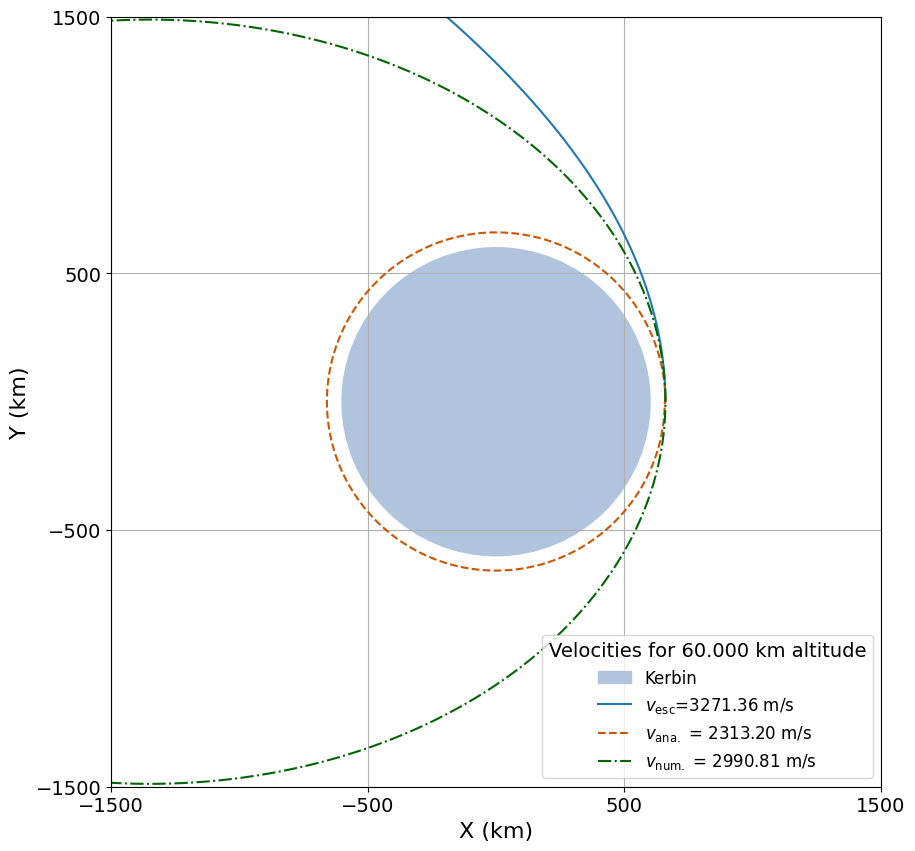

In [10]:
plot_with_crit_v()

In [17]:
def compare_velocities():

    """
    Modified version to calculate critical velocity using radius of curvature,
    takes much longer than above version
    """

    # Prompt user for planet and starting altitude
    planet_name = input("Enter planet name: ").strip().title()
    planet = PLANETS.get(planet_name)  
    if planet is None:
        raise ValueError(f"Planet '{planet_name}' not recognized. Please choose from: {list(PLANETS.keys())}")
    
    altitude= float(input("Enter orbital altitude in km:"))
    altitude_m = altitude*1_000

    v_min = float(input("Enter minimum velocity in m/s:"))
    v_max = float(input("Enter maximum velocity in m/s:"))
    n_runs = int(input("Enter number of velocities to check:"))

    velocities = np.linspace(v_min, v_max, n_runs)

    paths = [] # create list for paths to be stored
    
    # Loop through velocities and plot each trajectory

    for v in velocities:
        (_,_,_,_, xs, ys, _) = run_trajectory(
            v_r0 = v, 
            planet=planet,
            h0=altitude_m,
            dt=0.1,
            t_max=10_000,
            store_path = True
        )
        paths.append((v,xs,ys))

    # Calculate analytical solutions
    v_circ = np.sqrt(planet["mu"]/(planet["R"] + (altitude_m)))
    v_esc = np.sqrt((2*planet["mu"])/(planet["R"] + altitude_m))

    # Run trajectory for circular velocity
    an_impact_t, an_R, an_R_orbit, an_ts, an_xs, an_ys, an_final_r = run_trajectory(
        v_r0 = v_circ, 
        planet=planet, 
        h0 = altitude_m,
        dt=0.1,
        t_max=10_000,
        store_path=True)
    
    # Run trajectory for escape velocity
    escape_impact_t, escape_R, escape_R_orbit, escape_ts, escape_xs, escape_ys, esc_final_r = run_trajectory(
        v_r0 = v_esc, 
        planet=planet, 
        h0 = altitude_m,
        dt=0.1,
        t_max=10_000,
        store_path=True)

    # Plots
    fig, ax = plt.subplots(figsize=(10, 10))

    # Add a filled circle for the planet
    planet_radius_km = planet["R"] / 1e3
    planet_surface = plt.Circle((0, 0), planet_radius_km, color="lightsteelblue", label=f"{planet_name}", zorder=0)
    ax.add_patch(planet_surface)

    # Plot the analytical trajectories    
    ax.plot((escape_xs)/1e3, escape_ys/1e3, label=fr"$v_{{\mathrm{{esc}}}}$={v_esc:.2f} m/s")
    ax.plot((an_xs) / 1e3, an_ys / 1e3, label=fr"$v_{{\mathrm{{ana.}}}}$ = {v_circ:.2f} m/s", color="#CC5500", linestyle="--")
    
    # Plot the tested trajectories
    base_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red",
                    "tab:purple", "tab:brown", "tab:pink", "tab:gray",
                    "tab:olive", "tab:cyan"]
    
    for i, (v, xs, ys) in enumerate(paths):
            color = base_colors[i % len(base_colors)]
            ax.plot(xs/1e3, ys/1e3, color=color, linewidth=1, label=f"{v:.0f} m/s")

    # Limits and labels
    ax.set_aspect("equal")
    ax.set_xlabel("X (km)", fontsize=16)
    ax.set_ylabel("Y (km)", fontsize=16)
    ax.set_ylim((-2*planet["R"])/1e3, (2*planet["R"])/1e3)
    ax.set_xlim((-2*planet["R"])/1e3, (2*planet["R"])/1e3)

    # Axes
    #ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0)) # force scientific notation
    xt = ax.get_xticks()
    ax.set_xticks(xt[::2]) # set to show every other tick for readability
    yt = ax.get_yticks()
    ax.set_yticks(yt[::2])
    ax.tick_params(axis='both', labelsize=14)

    # Drop legend to two columns automatically if it gets crowded
    ncol = 2 if len(paths) > 10 else 1
    ax.legend(title=f"{int(round(altitude))} km altitude",
              fontsize=9, title_fontsize=11, ncol=ncol)

    ax.grid(True)
    plt.show()

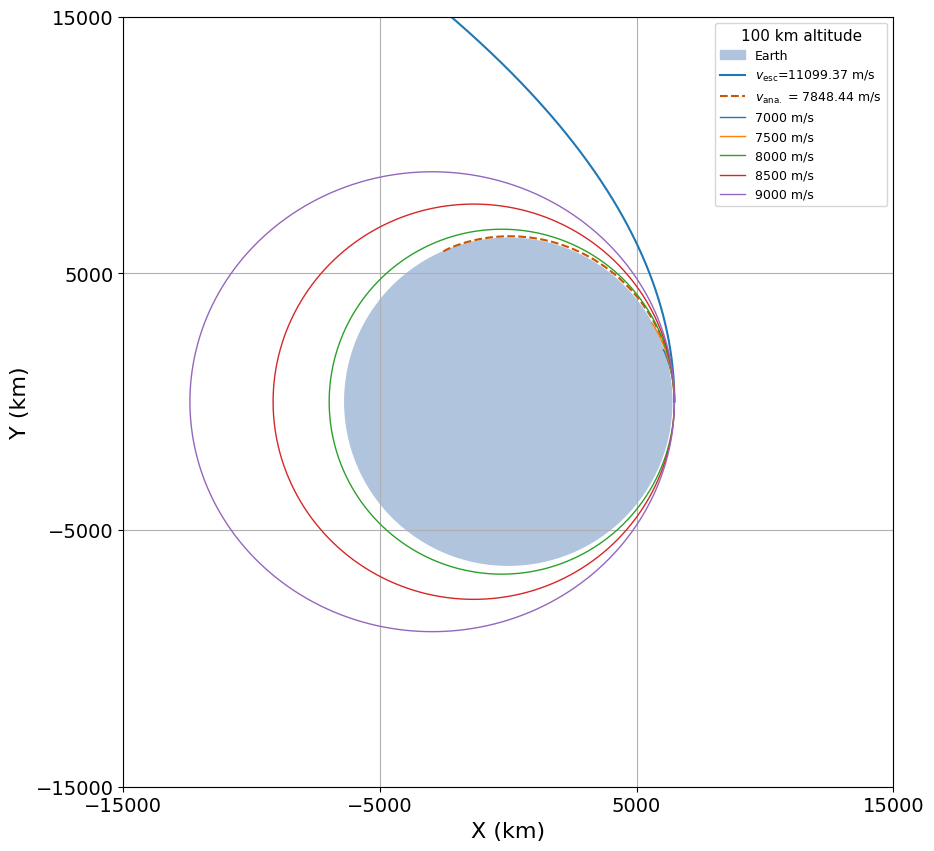

In [20]:
compare_velocities()